#  LDA, Multivariate Classification(Linear, LogR, KNN, CT), Support Vector Machines (Multivariate) with Various Kernels (Linear, RBF, Poly)

In this worksheet, we will practice classification using various reference methods ([LDA](https://scikit-learn.org/1.5/modules/lda_qda.html), [LR](https://scikit-learn.org/1.5/modules/linear_model.html#logistic-regression), [NN](https://scikit-learn.org/1.5/modules/neighbors.html), [CT](https://scikit-learn.org/1.5/modules/tree.html#)) and [SVM](https://scikit-learn.org/1.5/modules/svm.html), and measure their [performance](https://scikit-learn.org/1.5/modules/model_evaluation.html#classification-metrics). 
LDA is a special case of QDA, where the Gaussians for each class are assumed to share the same covariance matrix.


##### Data Load
We first load the classic [Wisconsin Diagnostic Breast Cancer (WDBC) Data](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic), used to diagnose breast cancer from biopsy samples based on 30 features of the tissue cells. 

In [1]:
import numpy as np;import pandas as pd;import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

tmp = load_breast_cancer() # load dictinary of 'target' (y) and 'data' (X)  variables
wdbc = pd.DataFrame( data= np.c_[ tmp['target'], tmp['data'] ], # make pandas DataFrame
    columns= ['diagnosis', 'radius_m', 'texture_m', 'perimeter_m','area_m', 'smoothness_m', 'compactness_m', 'concavity_m',
    'concave_points_m', 'symmetry_m', 'fractal_dimension_m', 'radius_se', 'texture_se', 'perimeter_se','area_se',
    'smoothness_se', 'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se', 
    'radius_w', 'texture_w','perimeter_w', 'area_w', 'smoothness_w', 'compactness_w', 'concavity_w',
    'concave_points_w','symmetry_w', 'fractal_dimension_w'])
# diagnosis = 0.0 -> malignant tumor; diagnosis = 1.0 -> benign tumor; 
wdbc.diagnosis = np.where( wdbc.diagnosis == 0.0, "malignant", "benign")
wdbc.sample(3, random_state=123) # Randomly selects 3 rows from the wdbc DataFrame.

,diagnosis,radius_m,texture_m,perimeter_m,area_m,smoothness_m,compactness_m,concavity_m,concave_points_m,symmetry_m,...,radius_w,texture_w,perimeter_w,area_w,smoothness_w,compactness_w,concavity_w,concave_points_w,symmetry_w,fractal_dimension_w
333,benign,11.250,14.78,71.38,390.0,0.08306,0.04458,0.000974,0.002941,0.1773,...,12.76,22.06,82.08,492.7,0.1166,0.09794,0.005518,0.01667,0.2815,0.07418
273,benign,9.742,15.67,61.50,289.9,0.09037,0.04689,0.011030,0.014070,0.2081,...,10.75,20.88,68.09,355.2,0.1467,0.09370,0.040430,0.05159,0.2841,0.08175
201,malignant,17.540,19.32,115.10,951.6,0.08968,0.11980,0.103600,0.074880,0.1506,...,20.42,25.84,139.50,1239.0,0.1381,0.34200,0.350800,0.19390,0.2928,0.07867


## 1. Linear Discriminant Analysis (LDA) 

### 1.1. Univariate Linear Classification

#### 1.1.1. LDA Model & decision boundary plot
The code below uses Linear Discriminant Analysis (LDA) to predict the diagnosis (classify tumors) based on the mean cell radius (`radius_m`), which is equivalent to **thresholding this feature**. The code below fits the LDA model and plots the decision boundary/threshold on a histogram. 

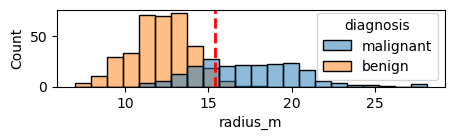

In [2]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

x = wdbc['radius_m'].to_numpy().reshape(-1,1); y = wdbc['diagnosis'].to_numpy()
clf = LDA() # define classifier (clf)
clf.fit(x, y)
radius_m_threshold = - (clf.intercept_ / clf.coef_) # threshold of 1D linear decision boundary 

import seaborn as sns
plt.figure(figsize=(5, 1)); sns.histplot( data = wdbc, x='radius_m', hue = 'diagnosis')
plt.axvline( radius_m_threshold, color = 'r', linestyle = "--", linewidth = 2 );

#### 1.1.2. In Sample Performance (confusion matrix, classification report) 
We now calculate the confusion matrix and various metrics for the *in-sample* performance of the LDA classifier:

In [3]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(x) # equivalent to thresholding predictions from: 
# y_pred = np.where( wdbc.radius_m < radius_m_threshold[0,0], "benign", "malignant" ) 

print( confusion_matrix( y, y_pred, labels=['malignant', 'benign']) ) # labesl used to reorder y-labels
print( classification_report( y, y_pred, labels=['malignant', 'benign']) )

[[149  63]
 [  8 349]]
              precision    recall  f1-score   support

   malignant       0.95      0.70      0.81       212
      benign       0.85      0.98      0.91       357

    accuracy                           0.88       569
   macro avg       0.90      0.84      0.86       569
weighted avg       0.89      0.88      0.87       569



In [4]:
from sklearn.metrics import confusion_matrix; import pandas as pd

conf_matrix = confusion_matrix(y, y_pred, labels=['malignant', 'benign'])
# Create a DataFrame to display the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=['y_malignant', 'y_benign'], columns=['y_pred_malignant', 'y_pred_benign'])
print(conf_matrix_df)

print("count y_pred=malignant, y=malignant:" ,sum ((y_pred=="malignant" ) * (y == "malignant") ) )
print("count y_pred=malignant, y=benign:" ,sum ((y_pred== "malignant") * (y =="benign" ) ) )

             y_pred_malignant  y_pred_benign
y_malignant               149             63
y_benign                    8            349
count y_pred=malignant, y=malignant: 149
count y_pred=malignant, y=benign: 8


#### 1.1.3. ROC-AUC
And we also create the ROC plot and calculate the AUC value:
 
`clf.predict_proba(x)[:,1]`: Extracts the probability of the positive class (malignant) for each data point. (0 for negative class)

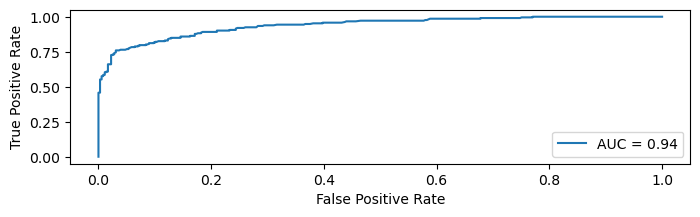

In [5]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, roc_auc_score

# Calculate ROC points ( FPR on x-axis, TPR on y-axis )
fpr, tpr, thresholds = roc_curve(y, x, pos_label='malignant') 
## Alternatively, you can predict the (posterior) probability of 'malignant' from LDA, and use that for the ROC/thresholding
# fpr, tpr, thresholds = roc_curve(y, clf.predict_proba(x)[:,1], pos_label='malignant') 

# Calculate AUC
AUC = auc(fpr, tpr) 
#AUC = roc_auc_score(y, x) #this calculate the AUC by thresholding a variable/probabilites directly 

# Plot ROC and AUC
fig, ax = plt.subplots(figsize=(8, 2)) ; 
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=AUC); roc_display.plot(ax=ax)


### 1.2.  Multivariate Linear Classification 

The classifier's performance can be improved by using all avalable features. 

              precision    recall  f1-score   support

      benign       0.95      0.99      0.97       357
   malignant       0.99      0.92      0.95       212

    accuracy                           0.96       569
   macro avg       0.97      0.95      0.96       569
weighted avg       0.97      0.96      0.96       569



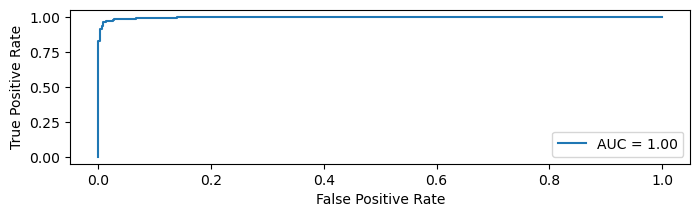

In [6]:
X = wdbc.drop('diagnosis', axis = 1).to_numpy()

clf_LDA = LDA() ; clf_LDA.fit(X, y)

print( classification_report( y, clf_LDA.predict(X)) )

fpr, tpr, thresholds = roc_curve(y, clf_LDA.predict_proba(X)[:,1], pos_label='malignant') 
# Plot ROC and AUC
fig, ax = plt.subplots(figsize=(8, 2)); 
roc_display = RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = auc(fpr, tpr)); roc_display.plot(ax=ax)

The *in-sample* performance is very good, but we might be overfitting. Randomly split the data into a training and test set with 75% and 25% of the observations respectively with `sklearn.model_selection.train_test_split()`. Measure the out-of-sample performance by running `sklearn.metrics.classification_report()` on the test set. 

In [7]:
X = wdbc.drop('diagnosis', axis = 1).to_numpy()
y = wdbc['diagnosis'].to_numpy()

# train_test split:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

clf_LDA = LDA()
clf_LDA.fit(X_train, y_train) # overwrites previously trained model
print( classification_report( y_test, clf_LDA.predict(X_test)) )

              precision    recall  f1-score   support

      benign       0.96      1.00      0.98        90
   malignant       1.00      0.92      0.96        53

    accuracy                           0.97       143
   macro avg       0.98      0.96      0.97       143
weighted avg       0.97      0.97      0.97       143



## 2. Other Multivariate classification analysis (LR,KNN,CT) 

Repeat the classification analysis above using Logistic Regression (`sklearn.linear_model.LogisticRegression()`), k-Nearest Neighbors (`sklearn.neighbors.KNeighborsClassifier()`), and Classification Trees (`sklearn.tree.DecisionTreeClassifier`), using default options. Calculate and print their classification report.

In [8]:
from sklearn.linear_model import LogisticRegression; from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# data prep
X = wdbc.drop('diagnosis', axis = 1).to_numpy()
y = wdbc['diagnosis'].to_numpy()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Logistic Regression
clf_LR = LogisticRegression()
clf_LR.fit(X_train, y_train)
y_pred_LR = clf_LR.predict(X_test)
print("Logistic Regression:")
print(classification_report(y_test, y_pred_LR))

# k-Nearest Neighbors (kNN)
clf_kNN = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
clf_kNN.fit(X_train, y_train)
y_pred_kNN = clf_kNN.predict(X_test)
print("\nk-Nearest Neighbors:")
print(classification_report(y_test, y_pred_kNN))

# Classification Tree
clf_CT = DecisionTreeClassifier()
clf_CT.fit(X_train, y_train)
y_pred_CT = clf_CT.predict(X_test)
print("\nClassification Tree:")
print(classification_report(y_test, y_pred_CT))


Logistic Regression:
              precision    recall  f1-score   support

      benign       0.98      0.93      0.95        90
   malignant       0.89      0.96      0.93        53

    accuracy                           0.94       143
   macro avg       0.94      0.95      0.94       143
weighted avg       0.95      0.94      0.94       143


k-Nearest Neighbors:
              precision    recall  f1-score   support

      benign       0.96      0.94      0.95        90
   malignant       0.91      0.92      0.92        53

    accuracy                           0.94       143
   macro avg       0.93      0.93      0.93       143
weighted avg       0.94      0.94      0.94       143


Classification Tree:
              precision    recall  f1-score   support

      benign       0.96      0.83      0.89        90
   malignant       0.77      0.94      0.85        53

    accuracy                           0.87       143
   macro avg       0.87      0.89      0.87       143
weighted 

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


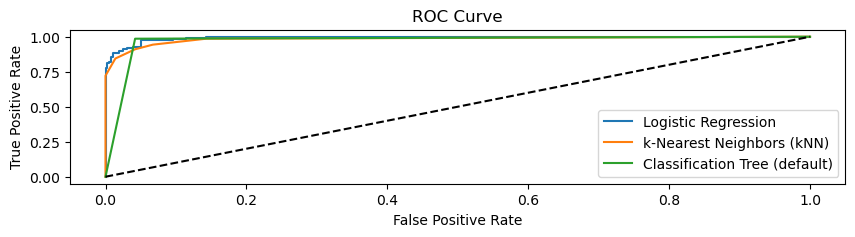

In [9]:
# Calculate ROC curves
from sklearn.metrics import roc_curve
fpr_log_reg, tpr_log_reg, _ = roc_curve(y, clf_LR.predict_proba(X)[:, 1], pos_label='malignant')
fpr_clf_kNN, tpr_clf_kNN, _ = roc_curve(y, clf_kNN.predict_proba(X)[:, 1], pos_label='malignant')
fpr_clf_CT, tpr_clf_CT, _ = roc_curve(y, clf_CT.predict_proba(X)[:, 1], pos_label='malignant')

# Plot ROC curves
plt.figure(figsize=(10, 2))
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression')
plt.plot(fpr_clf_kNN, tpr_clf_kNN, label=f'k-Nearest Neighbors (kNN)')
plt.plot(fpr_clf_CT, tpr_clf_CT, label=f'Classification Tree (default)')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate');plt.ylabel('True Positive Rate');plt.title('ROC Curve');plt.legend(loc='best');plt.show()

## 3. Support Vector Machines (Multivariate)

### 3.1.  linear (non-kernel) SVM classifier
Use a linear (non-kernel) SVM classifier (`sklearn.svm.LinearSVC`) on the same data, and report its out-of-sample performance.
Use the option `dual = 'auto'`, which will automatically choose the best optimization formulation (primal or dual) to solve.

In [10]:
# data prep
X = wdbc.drop('diagnosis', axis = 1).to_numpy(); y = wdbc['diagnosis'].to_numpy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

### Linear SVM
from sklearn.svm import LinearSVC
clf_LSVC = LinearSVC( dual = 'auto' ); clf_LSVC.fit( X_train, y_train )
y_pred_LSVC = clf_LSVC.predict(X_test)

print( classification_report(y_test, y_pred_LSVC, labels=['malignant','benign'] ) )

              precision    recall  f1-score   support

   malignant       0.93      0.98      0.95        53
      benign       0.99      0.96      0.97        90

    accuracy                           0.97       143
   macro avg       0.96      0.97      0.96       143
weighted avg       0.97      0.97      0.97       143



### 3.2.  (RBF kernel) SVM classifier

Repeat the previous part using an SVM with RBF kernel, which is the default option for `sklearn.svm.SVC`. Use an sklearn pipeline to standardize the features first; this is recommended for features with different scales, since there is only one kernel bandwidth coefficient for all features.

In [11]:
from sklearn.pipeline import make_pipeline;from sklearn.preprocessing import StandardScaler; from sklearn.svm import SVC

clf_SVC_RBF = make_pipeline(StandardScaler(), SVC(gamma='auto')); clf_SVC_RBF.fit(X_train, y_train)
y_pred_SVC_RBF = clf_SVC_RBF.predict(X_test)

print( classification_report(y_test, y_pred_SVC_RBF, labels=['malignant','benign'] ) )

              precision    recall  f1-score   support

   malignant       0.96      0.94      0.95        53
      benign       0.97      0.98      0.97        90

    accuracy                           0.97       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.97      0.96       143



### 3.3.  (polynomial kernel) SVM classifier
Repeat the previous part using a Support Vector classifier with a polynomial kernel of degree 3.

In [12]:
from sklearn.svm import SVC; import matplotlib.pyplot as plt; from sklearn.inspection import DecisionBoundaryDisplay

svc_poly = SVC(kernel='poly', degree = 3, probability=True).fit(X_train,y_train)
y_pred_svc_poly = svc_poly.predict(X_test)

print( classification_report( y_test,y_pred_svc_poly) )

              precision    recall  f1-score   support

      benign       0.91      0.98      0.94        90
   malignant       0.96      0.83      0.89        53

    accuracy                           0.92       143
   macro avg       0.93      0.90      0.92       143
weighted avg       0.93      0.92      0.92       143

